In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os.path
from pathlib import Path
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix

In [2]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from tensorflow.keras.applications import ResNet50
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
def create_model():

     input_shape = (224, 224, 3)

     ResNet_model = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)

     ResNet_model.trainable = False
     model = keras.Sequential([
         ResNet_model,
         GlobalAveragePooling2D(),
         Flatten(),
         Dense(256, activation='relu'),
         Dense(1, activation='sigmoid')
         #Relu ==> if the values less than 0 relu make this all values equal to zero
         #sigmoid ==> outputs values in the range of 0 to 1.
         ])
     model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

     return model

Found 92 validated image filenames belonging to 2 classes.
Found 10 validated image filenames belonging to 2 classes.
Found 50 validated image filenames belonging to 2 classes.



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 1)                 257       
        

c:\Users\AKSHU\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


test loss: 0.27591
test acc: 92.00
1/1 [==============================] - 43s 43s/step


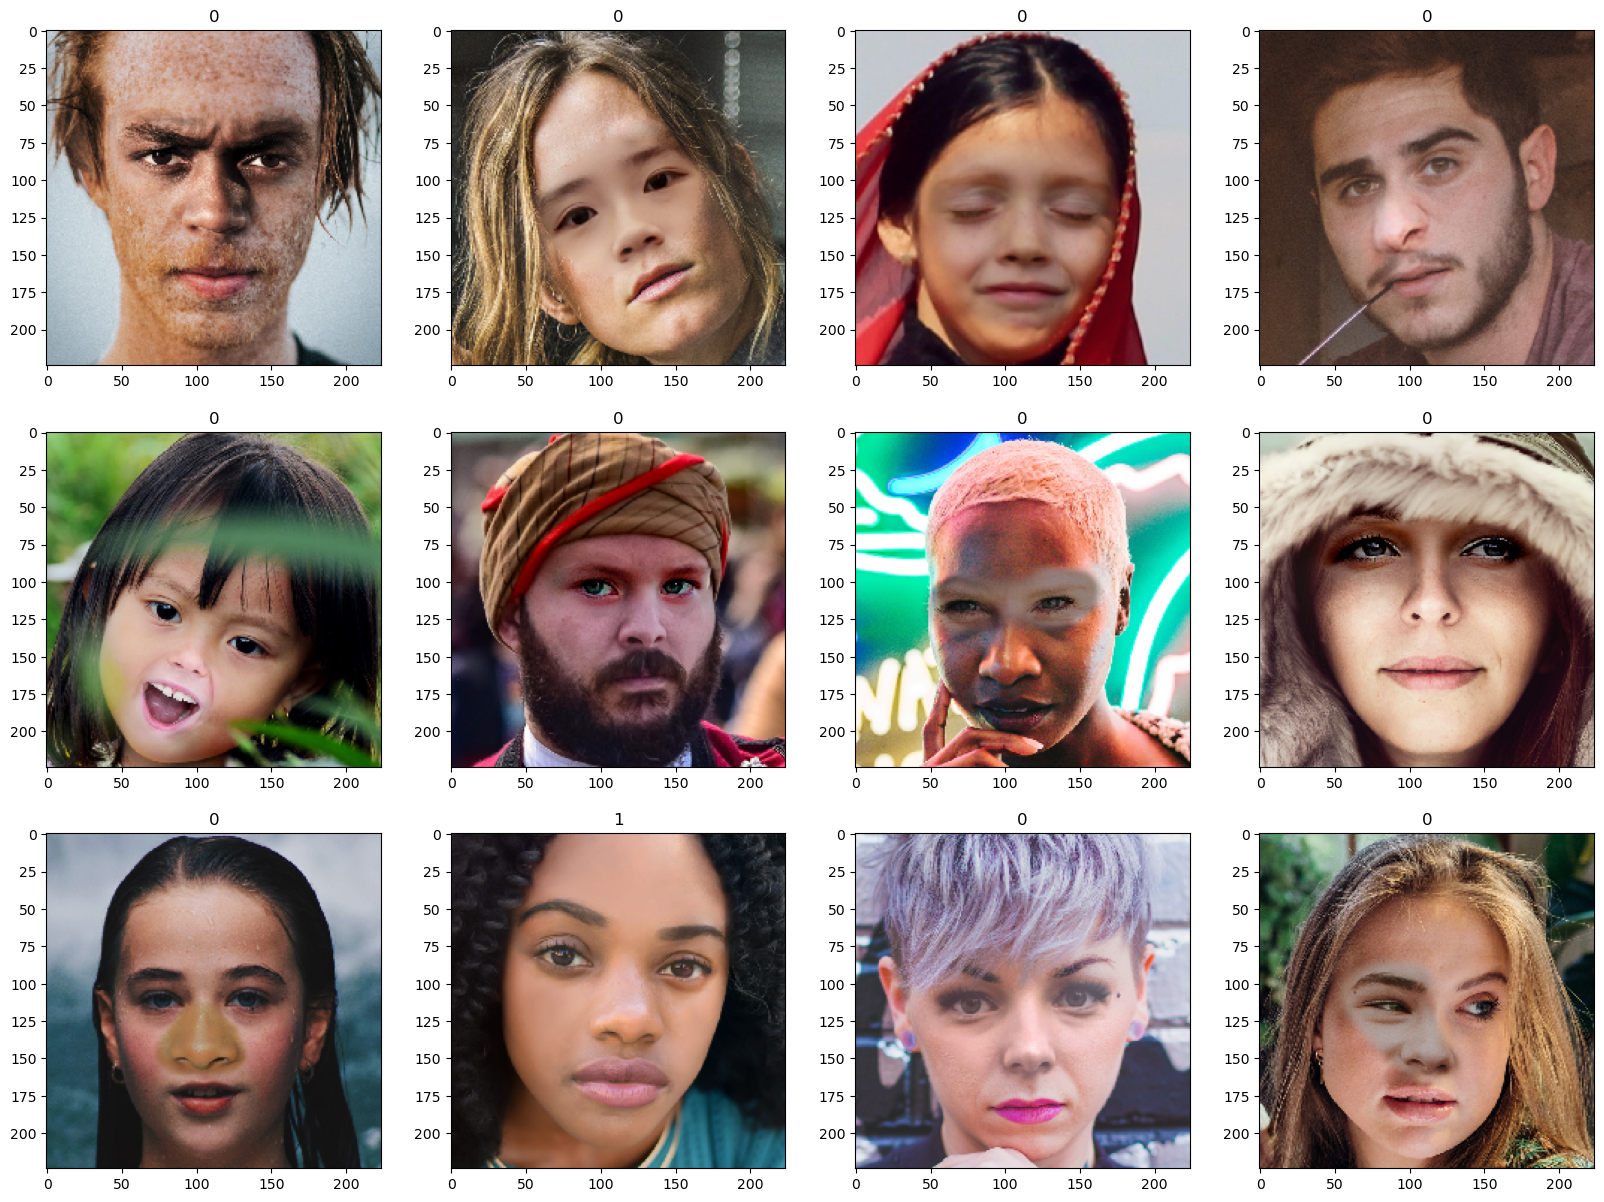

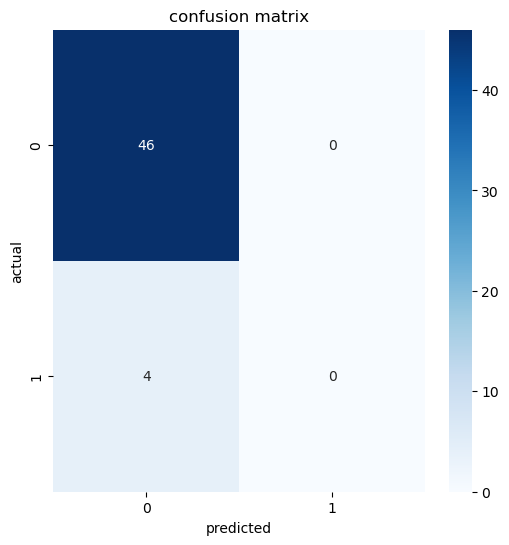

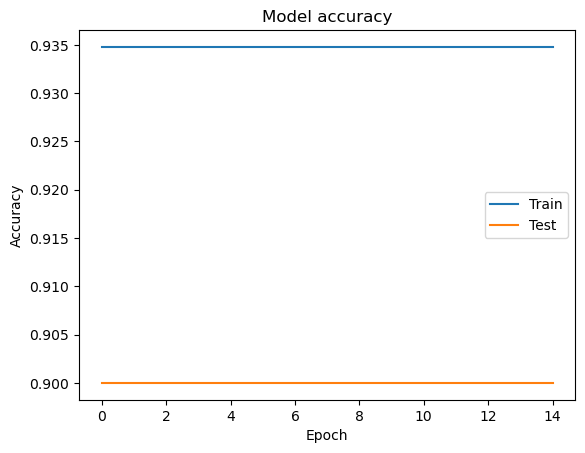

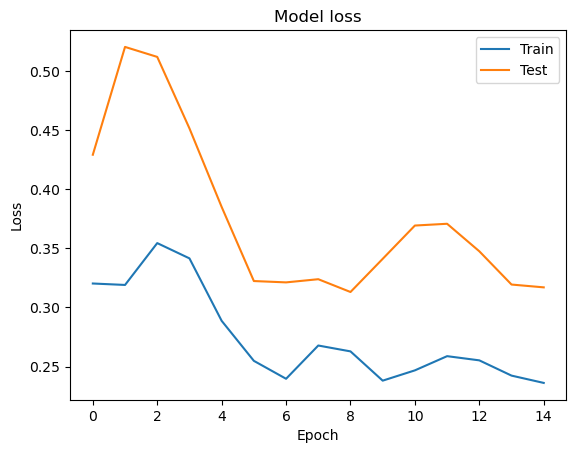

In [3]:
import zipfile
import os

image_dir=Path('E:/Final_Project/Deepfake/celeb-df')
filepaths= list(image_dir.glob(r'**/*.jpg'))
labels=list(map(lambda x: os.path.split(os.path.split(x)[0])[1],filepaths))
filepaths=pd.Series(filepaths,name='Filepath').astype(str)
labels=pd.Series(labels,name='Label')
image_df=pd.concat([filepaths,labels],axis=1)

train_df,test_df=train_test_split(image_df,train_size=0.7,shuffle=True,random_state=1)
train_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)
test_generator=tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255
)

train_images=train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images=train_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False,
    seed= 42,
    subset='validation'
)

test_images=test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='Filepath',
    y_col='Label',
    target_size=(224,224),
    color_mode='rgb',
    class_mode='binary',
    batch_size=64,
    shuffle=False
)

plt.figure(figsize=(20, 20))
for images, labels in train_images:
    for i in range(12):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i])
        plt.title(int(labels[i]))
        plt.axis("on")
    break

model=create_model()
model.summary()
history=model.fit(
    train_images,
    validation_data=val_images,
    epochs=20,

    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=6,
            restore_best_weights=True
        ),
         tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',
            patience=5
        )

    ]
)

model.save_weights('my_model_weights_resnet.h5')
model.save('resNet_model.h5')

results=model.evaluate(test_images,verbose=0)
print("test loss: {:.5f}".format(results[0]))
print("test acc: {:.2f}".format(results[1]*100))
predictions=(model.predict(test_images)>=0.5).astype(int)
cm=confusion_matrix(test_images.labels,predictions,labels=[0,1])
plt.figure(figsize=(6,6))
sns.heatmap(cm,annot=True,fmt='g',vmin=0,cmap='Blues',cbar=True)
plt.xticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.yticks(ticks=[0.5,1.5],label=["Fake","Real"])
plt.xlabel("predicted")
plt.ylabel("actual")
plt.title("confusion matrix")
plt.show()

plt.plot(history.history["accuracy"])
plt.plot(history.history["val_accuracy"])
plt.title("Model accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()


plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("Model loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Test"])
plt.show()